In [ ]:
#
# Copyright 2020 Spotify AB
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import numpy as np
from collections import defaultdict 
import matplotlib.pylab as plt
import matplotlib
matplotlib.use('Agg')

import json
from collections import defaultdict
from tensorflow.python.lib.io import file_io
tnums = 10

BASE_DIR = "ENTER_BASE_OUTPUT_PATH"

def offline_estimates(base_path):
    data = defaultdict(lambda : defaultdict(list))
    for tnum in range(tnums):
        json_str = file_io.read_file_to_string(
        '{BASE_DIR}/{base}/trial-{tnum}-results-00000-of-00001.json'.format(
            base=base_path, tnum=tnum))
        res_json = json.loads(json_str)
        for run, estimators in res_json.items():
            for est_name, est in estimators.items():
                data[run][est_name].append(est['est_mean'])
    return data
def online_estimates(base_path):
    gt_data = defaultdict(list)
    for tnum in range(tnums):
        json_str = file_io.read_file_to_string(
        '{BASE_DIR}/{base}/trial-{tnum}-onpolicy-00000-of-00001.json'.format(
            base=base_path,tnum=tnum))
        res_json = json.loads(json_str)
        for run, means in res_json.items():
            gt_data[run].append(means)
    return gt_data

def plot(data, gt_data, axs, i, cut_off_idx=10):

    est_names = ['OnlineEstimator', 'DynamicRIPSEstimator', 'IIPSEstimator', 
                 #'PIPSEstimator', 
                 #'RIPSEstimator', 
                 'NormIPSEstimator']
    for policy, results in sorted(data.items(), key=lambda x:x[0]):

        pidx = int(policy.split('-')[0]) - 1
        if policy == '1-ideal':
            policy_name = 'optimal'
        elif policy == '2-rand':
            policy_name = 'random'
        elif policy == '3-worst':
            policy_name = 'anti-optimal'            
        #axs[i, pidx].set_title(policy_name)
        
        # Add Online Estimator
        est_vals = [np.asarray(gt_data[policy])]

        # Add Offpolicy Estimators
        for est_name in est_names:
            if est_name == 'OnlineEstimator': continue
            est = np.asarray(results[est_name])
            est_vals.append(est[:,cut_off_idx])
        boxargs = {'showmeans':True,
                   'meanprops':dict(markerfacecolor='r', marker='s', markeredgecolor='r')}
        axs[i, pidx].boxplot(est_vals,**boxargs)
        display_names = []
        for n in est_names:
            if n == 'DynamicRIPSEstimator':
                display_names.append('RIPS')
            elif n == 'NormIPSEstimator':
                display_names.append('Std. IPS')                
            else:
                display_names.append(n.replace('Estimator', ''))
        plt.setp(axs, xticks=list(range(1, len(est_names) + 1)), xticklabels=display_names)
        

In [ ]:
def plot_matrix():
    fig, axs = plt.subplots(3, 3, figsize=(15,10), 
                            #sharex='col', sharey='row',
                            #gridspec_kw={'hspace': 0, 'wspace': 0}
                           )

    paths = [
        'nTracks-10_nCtx-10_nLogs5K_LoggingPolicy-opt',
        'nTracks-10_nCtx-10_nLogs5K_LoggingPolicy-rnd',
        'nTracks-10_nCtx-10_nLogs5K_LoggingPolicy-antiopt'
    ]
    for i, BASE_PATH in enumerate(paths):
        data = offline_estimates(BASE_PATH)
        gt_data = online_estimates(BASE_PATH)
        plot(data, gt_data, axs, i, cut_off_idx=3)


    for ax in axs.flat:
        ax.set(ylabel='average loss',
              ylim=[2,10])  
        ax.set(ylabel='average loss')         

    names = ['optimal', 'random', 'anti-optimal']
    #     for ax, row in zip(axs[:,0], names):
    #         ax.set_ylabel(row, rotation=90, size='large')
    for i, (ax, row) in enumerate(zip(axs[:,0], names)):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
        if i == 1:
            ax.annotate("Logging Policies", xy=(-8, 0.5), 
                        xytext=(-ax.yaxis.labelpad - 5, 0),
                        xycoords=ax.yaxis.label, 
                        textcoords='offset points', rotation='vertical',
                        size='xx-large', ha='right', va='center')
    for ax, col in zip(axs[0], names):
        ax.set_title(col)
    fig.suptitle('Target Policies',size='xx-large')
    for ax in fig.get_axes():
        ax.label_outer()  
    #plt.tight_layout()
    plt.savefig('./plot1.pdf', format='pdf')
plot_matrix()

In [ ]:

def plot_cutoffs(data, gt_data):
    fig, axs = plt.subplots(1, 3, figsize=(10,3), 
                            #sharex='col', sharey='row',
                            #gridspec_kw={'hspace': 0, 'wspace': 0}
                           )
    est_names = ['OnlineEstimator', 'DynamicRIPSEstimator', 'IIPSEstimator', 
                 #'PIPSEstimator', 
                 #'RIPSEstimator', 
                 'NormIPSEstimator']
    for cut_off_idx, c in enumerate([1, 3, 5,
                                     #10
                                    ]):
        policy = '3-worst'
        results = data[policy]
        #for policy, results in sorted(data.items(), key=lambda x:x[0]):

        #pidx = int(policy.split('-')[0]) - 1
        if policy == '1-ideal':
            policy_name = 'anti-optimal'
        elif policy == '2-rand':
            policy_name = 'random'
        elif policy == '3-worst':
            policy_name = 'optimal'            
        axs[cut_off_idx].set_title('Slate Size = {}'.format(c))

        # Add Online Estimator
        
        est_vals = [np.asarray(gt_data[policy])[:, cut_off_idx]]

        # Add Offpolicy Estimators
        for est_name in est_names:
            if est_name == 'OnlineEstimator': continue
            est = np.asarray(results[est_name])
            est_vals.append(est[:,cut_off_idx])
        boxargs = {'showmeans':True,
                   'meanprops':dict(markerfacecolor='r', marker='s', markeredgecolor='r')}
        axs[cut_off_idx].boxplot(est_vals,**boxargs)
        display_names = []
        for n in est_names:
            if n == 'DynamicRIPSEstimator':
                display_names.append('RIPS')
            elif n == 'NormIPSEstimator':
                display_names.append('Std. IPS')                
            else:
                display_names.append(n.replace('Estimator', ''))        
        plt.setp(axs, xticks=list(range(1, len(est_names) + 1)), xticklabels=display_names)

    #plot(data, gt_data, axs, 1, cut_off_idx=3)
    for ax in axs.flat:
        ax.set(ylabel='average loss', ylim=[0,6])  
        ax.set_ylabel(ylabel='average loss', fontsize=15)  
#         for tick in ax.get_xticklabels():
#             tick.set_rotation(90)
    for ax in fig.get_axes():
        ax.label_outer()
    plt.tight_layout()
    plt.savefig('./slate_size.pdf', format='pdf')

In [ ]:
BASE_PATH = 'nTracks-10_nCtx-10_nLogs5K_LoggingPolicy-opt2'
data = offline_estimates(BASE_PATH)
gt_data = online_estimates(BASE_PATH)

In [ ]:
plot_cutoffs(data, gt_data)

In [ ]:
from collections import defaultdict
from tensorflow.python.lib.io import file_io
import pandas as pd
import json

def real_data_results():
    userdata = defaultdict(dict)

    json_str = file_io.read_file_to_string(
    'gs://bandits4experimentation/neurips/test_userdata_0_0001/results-00000-of-00001.json')
    res_json = json.loads(json_str)
    for run, estimators in res_json.items():
        for est_name, est in estimators.items():
            userdata[run][est_name] = est
    cut_offs = [1, 3, 5, 10]
    table = defaultdict(list)
    rd = lambda x: round(x, 3)
    for idx, c in enumerate(cut_offs):
        if c != 5: continue
        for run_name in sorted(userdata.keys()):
            data = userdata[run_name]
            table['run'].append(run_name)
            table['CutOff'].append(c)        

            for est_name, rdata in data.items():
                if 'OnPolicy' in est_name:
                    table[est_name].append('{} ({})'.format(
                        rd(rdata['est_mean'][c-1]), 
                        rd(1.96 * rdata['est_std'][c-1])))
                elif 'IPS' in est_name:
                    table[est_name].append('{} ({})'.format(
                        rd(rdata['est_mean'][idx]), 
                        rd(1.96 * rdata['est_std'][idx])))
                else:
                    table[est_name].append('{} ({})'.format(
                        rd(rdata['est_mean'][idx]), 
                        rd(1.96 * rdata['est_std'][idx])))
    return pd.DataFrame(table)     
real_data_results()

In [ ]:
userdata = defaultdict(dict)
json_str = file_io.read_file_to_string(
'gs://bandits4experimentation/neurips/test_userdata_0_0005/results-00000-of-00001.json')
res_json = json.loads(json_str)
for run, estimators in res_json.items():
    for est_name, est in estimators.items():
        userdata[run][est_name] = est

In [ ]:
run = 'w2v'
for pos, ess in sorted(userdata[run]['DynamicRIPSEstimator']['data'].items()):
    for idx, i in enumerate(ess):
        print(pos, idx, "ESS: {:>9}".format(round(i['ess'], 4)),  "  LB: {}".format(i['lookback']))

In [ ]:
def print_table():
    paths = [
        'nTracks-10_nCtx-10_nLogs5K_LoggingPolicy-opt',
        'nTracks-10_nCtx-10_nLogs5K_LoggingPolicy-rnd',
        'nTracks-10_nCtx-10_nLogs5K_LoggingPolicy-antiopt'
    ]
    cut_off_idx = 3
    for i, BASE_PATH in enumerate(paths):
        data = offline_estimates(BASE_PATH)
        gt_data = online_estimates(BASE_PATH)
        est_names = ['DynamicRIPSEstimator', 'IIPSEstimator', 
                     #'PIPSEstimator', 
                     #'RIPSEstimator', 
                     'NormIPSEstimator']
        rmse = defaultdict(list)
        for policy, results in sorted(data.items(), key=lambda x:x[0]):

            pidx = int(policy.split('-')[0]) - 1
            if policy == '1-ideal':
                policy_name = 'optimal'
            elif policy == '2-rand':
                policy_name = 'random'
            elif policy == '3-worst':
                policy_name = 'anti-optimal'            
            #axs[i, pidx].set_title(policy_name)

            # Add Online Estimator
            est_vals = []
            online= np.asarray(gt_data[policy])
            # Add Offpolicy Estimators
            for est_name in est_names:
                if est_name == 'OnlineEstimator': continue
                est = np.asarray(results[est_name])
                est_vals.append(np.mean(online - est[:,cut_off_idx]))
                rmse[est_name].extend((online - est[:,cut_off_idx])**2)
        print(rmse.keys())
        print(np.around([np.sqrt(np.mean(v)) for k, v in rmse.items()], decimals=4))
            

        print()
print_table()

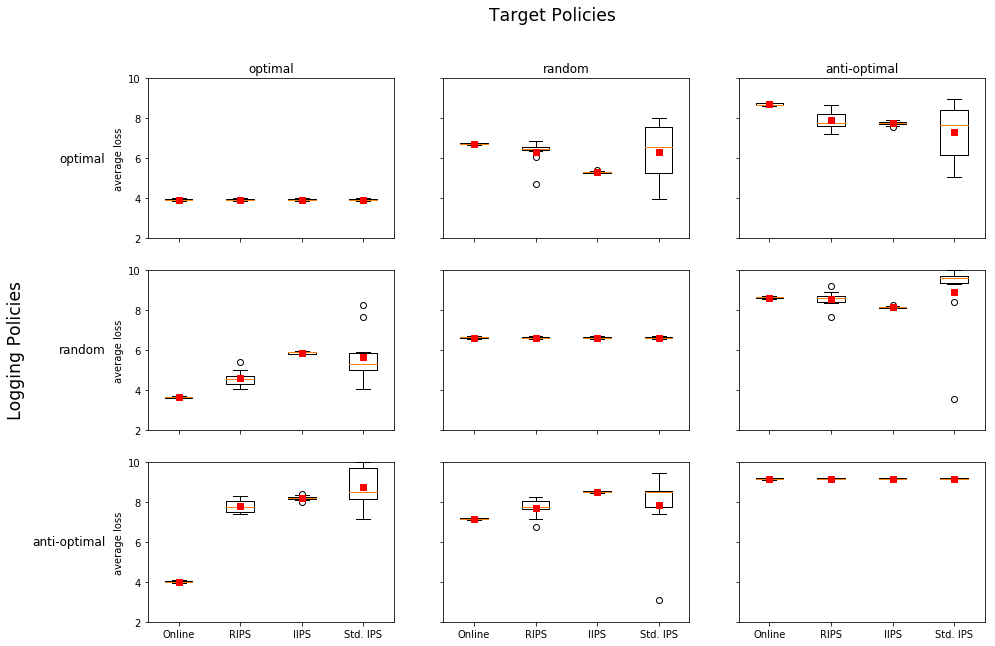

In [44]:
def plot_matrix():
    fig, axs = plt.subplots(3, 3, figsize=(15,10), 
                            #sharex='col', sharey='row',
                            #gridspec_kw={'hspace': 0, 'wspace': 0}
                           )

    paths = [
        'nTracks-10_nCtx-10_nLogs5K_LoggingPolicy-opt',
        'nTracks-10_nCtx-10_nLogs5K_LoggingPolicy-rnd',
        'nTracks-10_nCtx-10_nLogs5K_LoggingPolicy-antiopt'
    ]
    for i, BASE_PATH in enumerate(paths):
        data = offline_estimates(BASE_PATH)
        gt_data = online_estimates(BASE_PATH)
        plot(data, gt_data, axs, i, cut_off_idx=3)


    for ax in axs.flat:
        ax.set(ylabel='average loss',
              ylim=[2,10])  
        ax.set(ylabel='average loss')         

    names = ['optimal', 'random', 'anti-optimal']
    #     for ax, row in zip(axs[:,0], names):
    #         ax.set_ylabel(row, rotation=90, size='large')
    for i, (ax, row) in enumerate(zip(axs[:,0], names)):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
        if i == 1:
            ax.annotate("Logging Policies", xy=(-8, 0.5), 
                        xytext=(-ax.yaxis.labelpad - 5, 0),
                        xycoords=ax.yaxis.label, 
                        textcoords='offset points', rotation='vertical',
                        size='xx-large', ha='right', va='center')
    for ax, col in zip(axs[0], names):
        ax.set_title(col)
    fig.suptitle('Target Policies',size='xx-large')
    for ax in fig.get_axes():
        ax.label_outer()  
    #plt.tight_layout()
    plt.savefig('./plot1.pdf', format='pdf')
plot_matrix()

In [37]:

def plot_cutoffs(data, gt_data):
    fig, axs = plt.subplots(1, 3, figsize=(10,3), 
                            #sharex='col', sharey='row',
                            #gridspec_kw={'hspace': 0, 'wspace': 0}
                           )
    est_names = ['OnlineEstimator', 'DynamicRIPSEstimator', 'IIPSEstimator', 
                 #'PIPSEstimator', 
                 #'RIPSEstimator', 
                 'NormIPSEstimator']
    for cut_off_idx, c in enumerate([1, 3, 5,
                                     #10
                                    ]):
        policy = '3-worst'
        results = data[policy]
        #for policy, results in sorted(data.items(), key=lambda x:x[0]):

        #pidx = int(policy.split('-')[0]) - 1
        if policy == '1-ideal':
            policy_name = 'anti-optimal'
        elif policy == '2-rand':
            policy_name = 'random'
        elif policy == '3-worst':
            policy_name = 'optimal'            
        axs[cut_off_idx].set_title('Slate Size = {}'.format(c))

        # Add Online Estimator
        
        est_vals = [np.asarray(gt_data[policy])[:, cut_off_idx]]

        # Add Offpolicy Estimators
        for est_name in est_names:
            if est_name == 'OnlineEstimator': continue
            est = np.asarray(results[est_name])
            est_vals.append(est[:,cut_off_idx])
        boxargs = {'showmeans':True,
                   'meanprops':dict(markerfacecolor='r', marker='s', markeredgecolor='r')}
        axs[cut_off_idx].boxplot(est_vals,**boxargs)
        display_names = []
        for n in est_names:
            if n == 'DynamicRIPSEstimator':
                display_names.append('RIPS')
            elif n == 'NormIPSEstimator':
                display_names.append('Std. IPS')                
            else:
                display_names.append(n.replace('Estimator', ''))        
        plt.setp(axs, xticks=list(range(1, len(est_names) + 1)), xticklabels=display_names)

    #plot(data, gt_data, axs, 1, cut_off_idx=3)
    for ax in axs.flat:
        ax.set(ylabel='average loss', ylim=[0,6])  
        ax.set_ylabel(ylabel='average loss', fontsize=15)  
#         for tick in ax.get_xticklabels():
#             tick.set_rotation(90)
    for ax in fig.get_axes():
        ax.label_outer()
    plt.tight_layout()
    plt.savefig('./slate_size.pdf', format='pdf')

In [33]:
BASE_PATH = 'nTracks-10_nCtx-10_nLogs5K_LoggingPolicy-opt2'
data = offline_estimates(BASE_PATH)
gt_data = online_estimates(BASE_PATH)

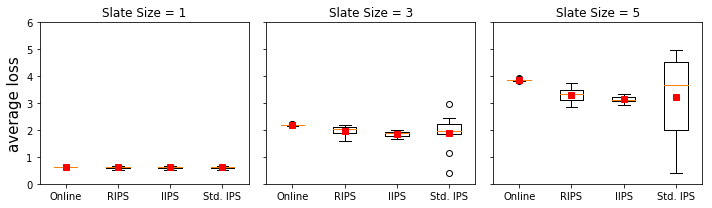

In [38]:
plot_cutoffs(data, gt_data)

In [312]:
from collections import defaultdict
from tensorflow.python.lib.io import file_io
import pandas as pd
import json

def real_data_results():
    userdata = defaultdict(dict)

    json_str = file_io.read_file_to_string(
    'gs://bandits4experimentation/neurips/test_userdata_0_0001/results-00000-of-00001.json')
    res_json = json.loads(json_str)
    for run, estimators in res_json.items():
        for est_name, est in estimators.items():
            userdata[run][est_name] = est
    cut_offs = [1, 3, 5, 10]
    table = defaultdict(list)
    rd = lambda x: round(x, 3)
    for idx, c in enumerate(cut_offs):
        if c != 5: continue
        for run_name in sorted(userdata.keys()):
            data = userdata[run_name]
            table['run'].append(run_name)
            table['CutOff'].append(c)        

            for est_name, rdata in data.items():
                if 'OnPolicy' in est_name:
                    table[est_name].append('{} ({})'.format(
                        rd(rdata['est_mean'][c-1]), 
                        rd(1.96 * rdata['est_std'][c-1])))
                elif 'IPS' in est_name:
                    table[est_name].append('{} ({})'.format(
                        rd(rdata['est_mean'][idx]), 
                        rd(1.96 * rdata['est_std'][idx])))
                else:
                    table[est_name].append('{} ({})'.format(
                        rd(rdata['est_mean'][idx]), 
                        rd(1.96 * rdata['est_std'][idx])))
    return pd.DataFrame(table)     
real_data_results()

,CutOff,DynamicRIPSEstimator,IIPSEstimator,NormIPSEstimator,PIPSEstimator,RIPSEstimator,run
0,5,2.397 (0.916),2.384 (0.153),3.754 (4.249),2.397 (0.916),3.317 (2.369),popularity
1,5,2.219 (0.023),2.227 (0.023),2.231 (0.024),2.222 (0.023),2.219 (0.023),random
2,5,1.998 (0.96),2.072 (0.128),2.161 (2.02),1.998 (0.96),2.236 (1.521),w2v


In [315]:
userdata = defaultdict(dict)
json_str = file_io.read_file_to_string(
'gs://bandits4experimentation/neurips/test_userdata_0_0005/results-00000-of-00001.json')
res_json = json.loads(json_str)
for run, estimators in res_json.items():
    for est_name, est in estimators.items():
        userdata[run][est_name] = est

In [316]:
run = 'w2v'
for pos, ess in sorted(userdata[run]['DynamicRIPSEstimator']['data'].items()):
    for idx, i in enumerate(ess):
        print(pos, idx, "ESS: {:>9}".format(round(i['ess'], 4)),  "  LB: {}".format(i['lookback']))

0 0 ESS:  887.9273   LB: 0
1 0 ESS:   623.022   LB: 0
1 1 ESS:   28.8754   LB: 1
2 0 ESS:  587.5027   LB: 0
2 1 ESS:   15.7873   LB: 1
3 0 ESS:  528.1784   LB: 0
3 1 ESS:   12.4945   LB: 1
4 0 ESS:  534.7696   LB: 0
4 1 ESS:    17.207   LB: 1
4 2 ESS:    1.2346   LB: 2
5 0 ESS:  489.2904   LB: 0
5 1 ESS:   16.0281   LB: 1
6 0 ESS:  545.5853   LB: 0
6 1 ESS:    2.9598   LB: 1
7 0 ESS:  538.4191   LB: 0
7 1 ESS:   15.6356   LB: 1
8 0 ESS:  480.0886   LB: 0
8 1 ESS:   16.9344   LB: 1
8 2 ESS:   35.7203   LB: 2
9 0 ESS:  478.8246   LB: 0
9 1 ESS:    6.6585   LB: 1


In [31]:
def print_table():
    paths = [
        'nTracks-10_nCtx-10_nLogs5K_LoggingPolicy-opt',
        'nTracks-10_nCtx-10_nLogs5K_LoggingPolicy-rnd',
        'nTracks-10_nCtx-10_nLogs5K_LoggingPolicy-antiopt'
    ]
    cut_off_idx = 3
    for i, BASE_PATH in enumerate(paths):
        data = offline_estimates(BASE_PATH)
        gt_data = online_estimates(BASE_PATH)
        est_names = ['DynamicRIPSEstimator', 'IIPSEstimator', 
                     #'PIPSEstimator', 
                     #'RIPSEstimator', 
                     'NormIPSEstimator']
        rmse = defaultdict(list)
        for policy, results in sorted(data.items(), key=lambda x:x[0]):

            pidx = int(policy.split('-')[0]) - 1
            if policy == '1-ideal':
                policy_name = 'optimal'
            elif policy == '2-rand':
                policy_name = 'random'
            elif policy == '3-worst':
                policy_name = 'anti-optimal'            
            #axs[i, pidx].set_title(policy_name)

            # Add Online Estimator
            est_vals = []
            online= np.asarray(gt_data[policy])
            # Add Offpolicy Estimators
            for est_name in est_names:
                if est_name == 'OnlineEstimator': continue
                est = np.asarray(results[est_name])
                est_vals.append(np.mean(online - est[:,cut_off_idx]))
                rmse[est_name].extend((online - est[:,cut_off_idx])**2)
        print(rmse.keys())
        print(np.around([np.sqrt(np.mean(v)) for k, v in rmse.items()], decimals=4))
            

        print()
print_table()

dict_keys(['IIPSEstimator', 'NormIPSEstimator', 'DynamicRIPSEstimator'])
[0.9858 1.379  0.663 ]

dict_keys(['IIPSEstimator', 'NormIPSEstimator', 'DynamicRIPSEstimator'])
[1.3169 1.7506 0.629 ]

dict_keys(['IIPSEstimator', 'NormIPSEstimator', 'DynamicRIPSEstimator'])
[2.5526 2.9713 2.2285]

